In [66]:
%matplotlib inline

import torch
import numpy as np
from matplotlib import pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 7)

# Définition du problème
Donnons-nous la fonction suivante à minimiser :

$$f(x) = 3x^2 + 6x + 1$$

$$f'(x) = 6x + 6$$

$f$ est minimale en $x^* = -1$ et on a $f(x^*) = -2$.

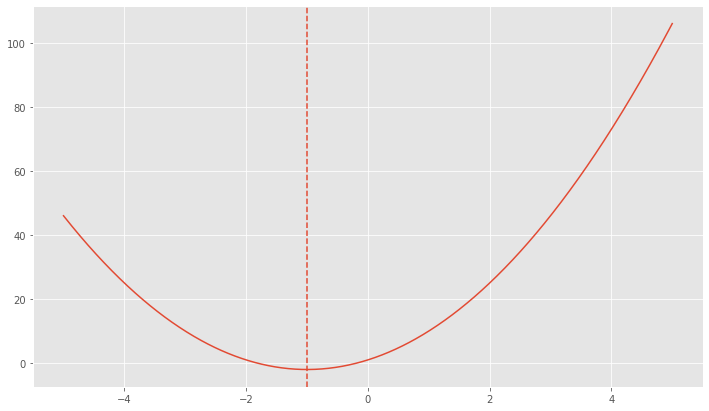

In [67]:
# Définition des variables
f = lambda x: 3*x**2 + 6*x + 1

Xs = np.linspace(-5, 5, 1000)
plt.plot(Xs, f(Xs))
plt.axvline(-1, ls="--", c="C0")

# Descente de gradient manuelle

In [19]:
f_prime = lambda x: 6*x + 6

X = 10
n_epochs = 20
learning_rate = 0.05

history = {"X": [], "f": []}
for epoch in range(n_epochs):
    history["X"].append(X)
    history["f"].append(f(X))
    print(f"{epoch:0>2d} -> X={X:.3f} f={f(X):.3f}")
    grad = f_prime(X)
    X = X - learning_rate * grad
history = pd.DataFrame(history)

00 -> X=10.000 f=361.000
01 -> X=6.700 f=175.870
02 -> X=4.390 f=85.156
03 -> X=2.773 f=40.707
04 -> X=1.641 f=18.926
05 -> X=0.849 f=8.254
06 -> X=0.294 f=3.024
07 -> X=-0.094 f=0.462
08 -> X=-0.366 f=-0.794
09 -> X=-0.556 f=-1.409
10 -> X=-0.689 f=-1.710
11 -> X=-0.782 f=-1.858
12 -> X=-0.848 f=-1.930
13 -> X=-0.893 f=-1.966
14 -> X=-0.925 f=-1.983
15 -> X=-0.948 f=-1.992
16 -> X=-0.963 f=-1.996
17 -> X=-0.974 f=-1.998
18 -> X=-0.982 f=-1.999
19 -> X=-0.987 f=-2.000


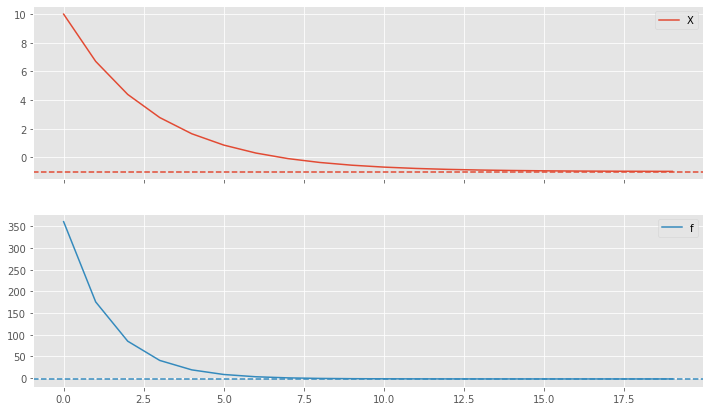

In [68]:
axes = history.plot(subplots=True)
axes[0].axhline(-1, ls="--", c="C0")
axes[1].axhline(-2, ls="--", c="C1")

# Calcul du gradient automatique par Pytorch

## Comment marche la différentiation automatique en Pytorch

Les objets de base en pytorch s'appellent les tensors et se comportent comme des arrays numpy.

In [76]:
x = torch.tensor([5], dtype=torch.float)
x

tensor([5.])

Si on veut utiliser pytorch pour obtenir le gradient d'une certaine fonction par rapport à un tensor, il faut activer le calcul des gradients pour ce tensor, de la manière suivante :

In [77]:
x.requires_grad_(True)
# On aurait aussi pu directement définir: torch.tensor([1], dtype=torch.float, requires_grad=True)
x

tensor([5.], requires_grad=True)

Maintenant que le calcul des gradients est activé pour ce tensor, calculons le gradient d'une fonction en ce point. Par exemple la fonction $x^3$.

In [78]:
output = x**3
output.backward() # Calcul du gradient et propagation de celui-ci à toutes les variables qui ont servi au calcul de output

Regardons le gradient obtenu :

In [79]:
x.grad

tensor([75.])

On obtient bien la dérivée attendue ($3\times 25^2 = 75$).

Maintenant, regardons la dérivée d'une fonction plus compliquée :

$$f(x) = \sin(\log(\sqrt{x} + 3))$$

In [83]:
# On remet le gradient à 0 avant de calculer d'autres gradients
x.grad.zero_()
x.grad

tensor([0.])

In [84]:
output = torch.sin(torch.log(torch.sqrt(x) + 3))
output.backward()
x.grad

tensor([-0.0036])

Les plus courageux pourront vérifier que cette dérivée est bien correcte.

## Check que le gradient de f est bon

Vérifions d'abord que le gradient calculé par pytorch correspond à la valeur de la dérivée de la fonction.

In [37]:
X = torch.tensor([10], dtype=torch.float, requires_grad=True)
X

tensor([10.], requires_grad=True)

In [38]:
result = f(X)
result

tensor([361.], grad_fn=<AddBackward0>)

In [40]:
result.backward()
X

tensor([10.], requires_grad=True)

In [41]:
X.grad

tensor([66.])

In [42]:
f_prime(10)

66

## Descente de gradient en pytorch

In [56]:
X = torch.tensor([10], dtype=torch.float, requires_grad=True)
n_epochs = 20
learning_rate = 0.05

for epoch in range(n_epochs):
    result = f(X)
    print(f"{epoch:0>2d} -> X={X.item():.3f} f={result.item()}")
    
    result.backward()
    with torch.no_grad():
        X -= learning_rate * X.grad
    X.grad.zero_()


00 -> X=10.000 f=361.0
01 -> X=6.700 f=175.86997985839844
02 -> X=4.390 f=85.15629577636719
03 -> X=2.773 f=40.706581115722656
04 -> X=1.641 f=18.926223754882812
05 -> X=0.849 f=8.253849029541016
06 -> X=0.294 f=3.0243866443634033
07 -> X=-0.094 f=0.46194934844970703
08 -> X=-0.366 f=-0.793644905090332
09 -> X=-0.556 f=-1.4088859558105469
10 -> X=-0.689 f=-1.7103543281555176
11 -> X=-0.782 f=-1.8580737113952637
12 -> X=-0.848 f=-1.9304559230804443
13 -> X=-0.893 f=-1.9659233093261719
14 -> X=-0.925 f=-1.983302354812622
15 -> X=-0.948 f=-1.9918181896209717
16 -> X=-0.963 f=-1.9959909915924072
17 -> X=-0.974 f=-1.9980359077453613
18 -> X=-0.982 f=-1.999037504196167
19 -> X=-0.987 f=-1.999528408050537


Le résultat est très similaire à la descente de gradient manuelle.

## Utilisation d'un optimizer
L'optimizer gère la descente de gradient à notre place, en faisant plein de trucs smarts pour ne pas être bloqué dans des optimas locaux.

Malheureusement, dans un cas aussi gentil qu'une fonction quadratique, il fonctionne moins bien que la descente de gradient basique.

In [65]:
X = torch.tensor([10], dtype=torch.float, requires_grad=True)
n_epochs = 100
learning_rate = 0.3
optimizer = torch.optim.Adam([X], lr=learning_rate)

for epoch in range(n_epochs):
    result = f(X)
    print(f"{epoch:0>2d} -> X={X.item():.3f} f={result.item()}")
    
    result.backward()
    
    optimizer.step()
    optimizer.zero_grad()


00 -> X=10.000 f=361.0
01 -> X=9.700 f=341.469970703125
02 -> X=9.400 f=322.4952697753906
03 -> X=9.101 f=304.0849914550781
04 -> X=8.802 f=286.24737548828125
05 -> X=8.504 f=268.9898986816406
06 -> X=8.207 f=252.31884765625
07 -> X=7.911 f=236.23971557617188
08 -> X=7.617 f=220.75677490234375
09 -> X=7.324 f=205.87307739257812
10 -> X=7.033 f=191.59063720703125
11 -> X=6.744 f=177.91015625
12 -> X=6.457 f=164.83103942871094
13 -> X=6.173 f=152.3514404296875
14 -> X=5.891 f=140.4681396484375
15 -> X=5.613 f=129.17665100097656
16 -> X=5.337 f=118.47109985351562
17 -> X=5.065 f=108.34431457519531
18 -> X=4.796 f=98.78775024414062
19 -> X=4.531 f=89.7916030883789
20 -> X=4.271 f=81.34481811523438
21 -> X=4.014 f=73.43507385253906
22 -> X=3.763 f=66.04890441894531
23 -> X=3.516 f=59.17173767089844
24 -> X=3.273 f=52.78792953491211
25 -> X=3.037 f=46.88090896606445
26 -> X=2.805 f=41.433204650878906
27 -> X=2.579 f=36.426570892333984
28 -> X=2.359 f=31.842079162597656
29 -> X=2.144 f=27.660